In [1]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_colwidth = 1000

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load the Data

In [3]:
d = pd.read_csv('tmp/train_ids.csv', index_col='id')

In [4]:
e = pd.read_csv('tmp/features_bathrooms.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [5]:
e = pd.read_csv('tmp/features_bedrooms.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [6]:
e = pd.read_csv('tmp/features_building_id.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [7]:
e = pd.read_csv('tmp/features_created.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [8]:
e = pd.read_csv('tmp/features_description.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [9]:
e = pd.read_csv('tmp/features_display_address.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [10]:
e = pd.read_csv('tmp/features_features.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [11]:
e = pd.read_csv('tmp/features_latlon.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [12]:
e = pd.read_csv('tmp/features_manager_id.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [13]:
e = pd.read_csv('tmp/features_photos.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [14]:
e = pd.read_csv('tmp/features_price.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [15]:
e = pd.read_csv('tmp/features_street_address.csv', index_col='id')
d = pd.merge(d, e, how='left', left_index=True, right_index=True)

In [16]:
labels = d.interest_level.copy()

In [17]:
for c in d.columns:
    if d.dtypes[c] not in ('int64', 'float64'):
        del d[c]

# Run Classification

In [41]:
param_grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [30, 35, 40],
    'objective': ['multi:softprob']
}
xgb = XGBClassifier()
m = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=3,
        scoring='neg_log_loss',
        verbose=1)
m.fit(d, labels)
print m.best_score_
print m.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.0min finished


-0.642974613444
{'n_estimators': 35, 'objective': 'multi:softprob', 'max_depth': 3}


In [48]:
param_grid = {
    'max_depth': [3],
    'n_estimators': [35],
    'min_child_weight': [3],
    'learning_rate': [0.1],
    'objective': ['multi:softprob']
}
xgb = XGBClassifier()
m = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=3,
        scoring='neg_log_loss',
        verbose=1)
m.fit(d, labels)
print m.best_score_
print m.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min finished


-0.642937995347
{'n_estimators': 35, 'objective': 'multi:softprob', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3}


In [51]:
xgb = XGBClassifier(
    max_depth=3,
    n_estimators=35,
    min_child_weight=3,
    learning_rate=0.1,
    objective='multi:softprob',
    silent=0)
xgb.fit(d, labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=35, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=0, subsample=1)

In [52]:
fi = pd.DataFrame({'feature': d.columns, 'importance': xgb.feature_importances_})
fi = fi.sort_values(['importance'], ascending=False)

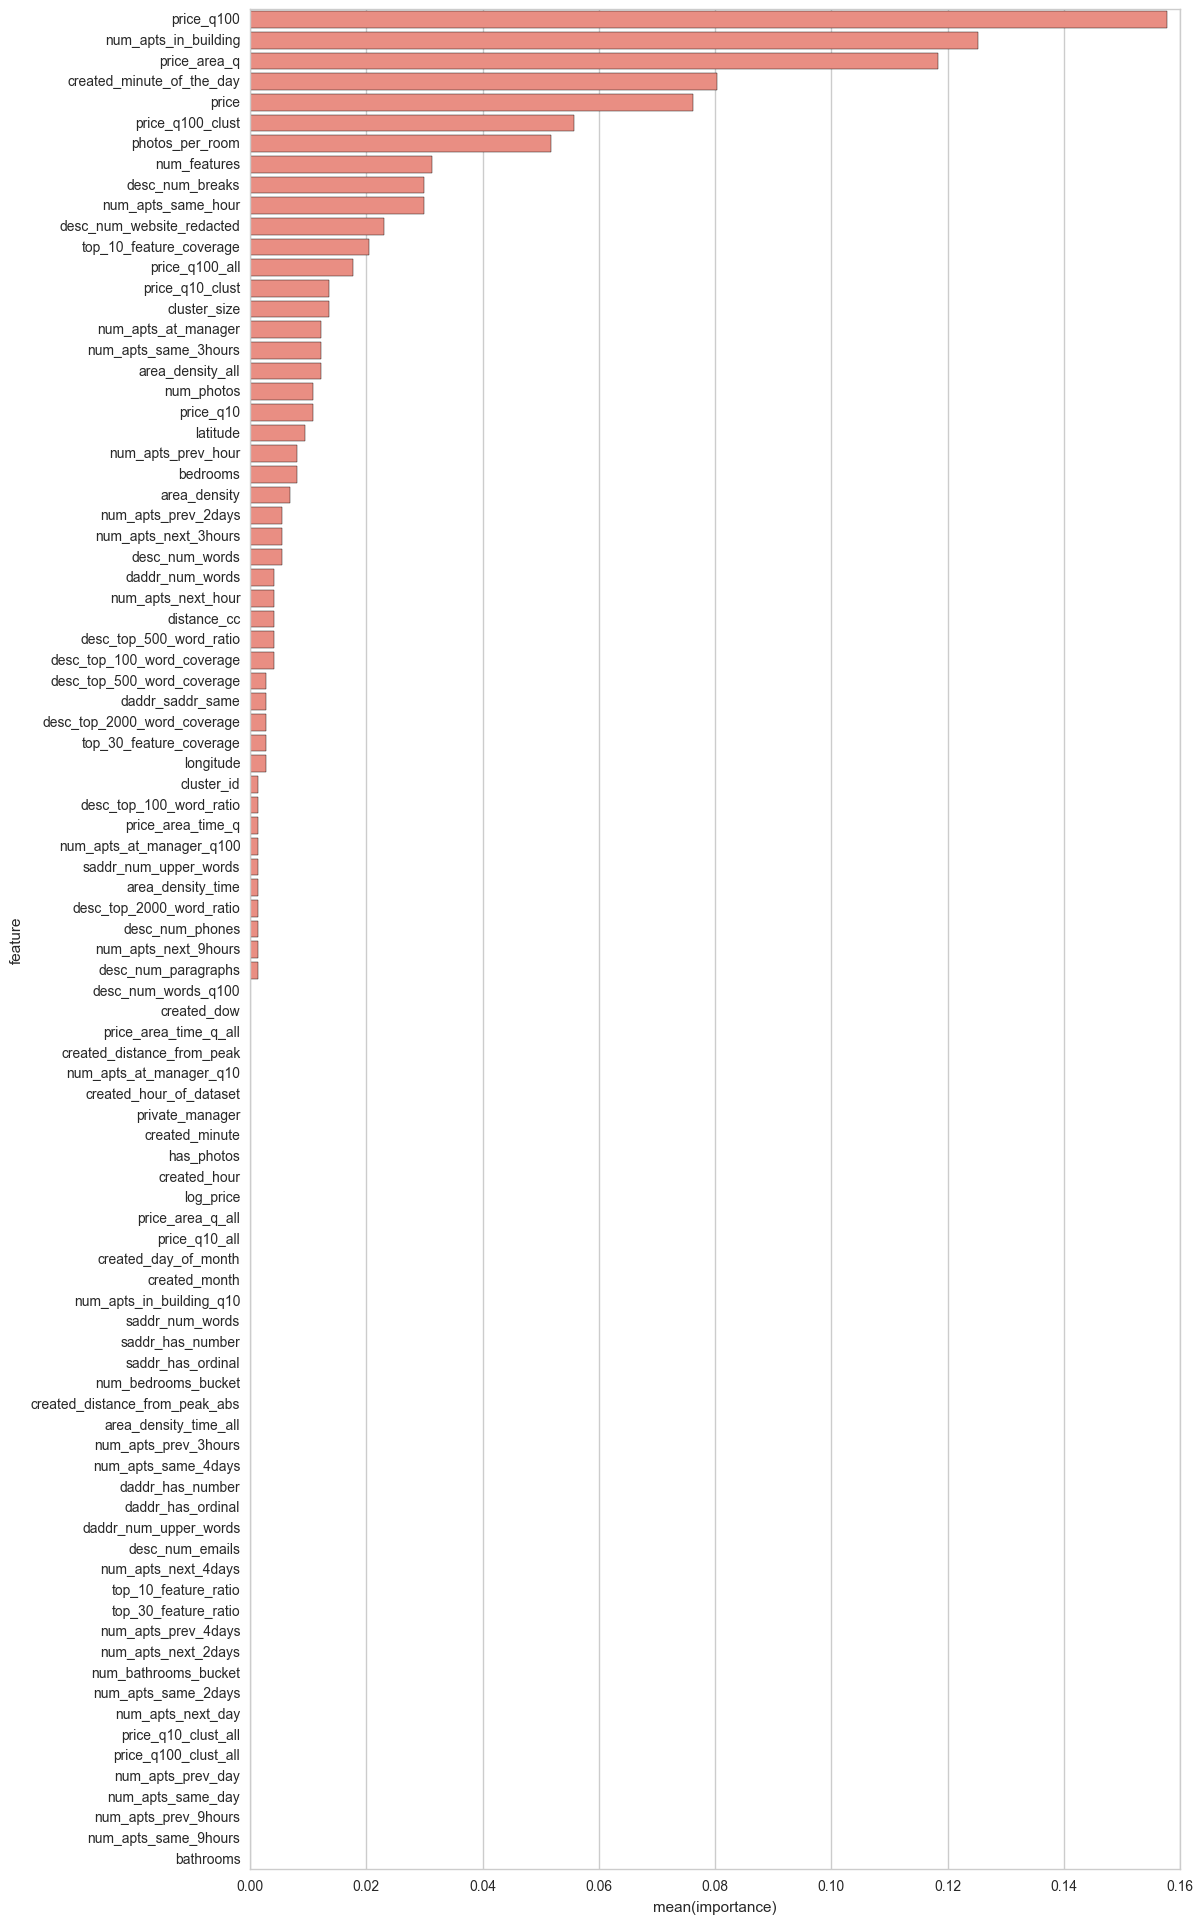

In [53]:
plt.figure(figsize=(12,24))
_ = sns.barplot(
        x='importance',
        y='feature',
        data=fi,
        color='salmon')